# ECNM10106 Programming for Economics
# Take-Home Exam, Section B

In [1]:
# Importing relevant libraries
import numpy as np

import matplotlib.pyplot as plt

from scipy import optimize, interpolate
from scipy.optimize import minimize_scalar
from scipy.interpolate import interp1d, RectBivariateSpline

np.random.seed(23)  # fix the seed at the beginning and only once.

import quantecon as qe
from quantecon import rouwenhorst

from copy import copy, deepcopy

import sys

# Exercise B1. Cake Eating Problem.
Consider the problem of a person with $x_0$ units of cake that they are thinking about eating. The trouble is, they have concave preferences over their cake consumption in each period, so they want to ensure that they don’t eat it all at once. In particular, assume that they have CRRA preferences $u(c) = c^{1−\sigma}/(1−\sigma)$, for $\sigma = 2.5$ and that they discount the future at a rate $\beta$. We’ll assume that they have access to a flawless refrigeration technology, so the cake does not spoil if they save some for the next day. Moreover, they have a special deal with the bakery: every day, the baker gives them one new unit of cake for free (so they will never run out).

Assume our consumer is infinitely lived. Then we can write their problem in sequence form as

\begin{equation*}
\begin{aligned}
    v(x_0)=\max_{c_t,x_{t+1}} \;\; & \sum_{t=0}^{\infty} \beta ^t u(c_t) \\ 
    \text{s.t. } \;\; & x_{t+1} = 1 + x_t - c_t \\ 
\end{aligned}
\end{equation*}

$a)$ Rewrite this dynamic program in its recursive formulation. That is, write $v(x)$ as a recursive maximization problem, where $v$ occurs both on the left-hand side, and on the right-hand size as a continuation value, of entering the next period with $x′$ units of cake. Describe the intuition for why we can re-write the problem in this way.

We can rewrite the problem in the following recursive manner:

\begin{equation*}
\begin{aligned}
    v(x)=\max_{c,x'} \;\; & u(c)+\beta v(x') \\ 
    \text{s.t. } \;\; & x' = 1 + x - c \\ 
\end{aligned}
\end{equation*}

The above formulation of the person's cake eating problem is called the Bellman equation formulation, in which we turned an infinite horizon optimization problem into a sequence of 1 dimensional optimination problems.

The intuition for why we can re-write the problem in this way lies in an algorithm called backwards induction, which works because the person's payoff in each time period only depends on the cake she takes into each new period and the choices she makes for the future. Consider a finite horizon case where $T = 2$. Her maximization problem in periods 1 and 2 are

\begin{equation*}
\begin{aligned}
    v_1(x_1)=\max_{c_1,c_2,x_2} \;\; & u(c_1)+\beta u(c_2) \\ 
    \text{s.t. } \;\; & x_2 = 1 + x_1 - c_1 \\ 
    \text{s.t. } \;\; & c_2 = 1 + x_2 \\ 
\end{aligned}
\end{equation*}

\begin{equation*}
\begin{aligned}
    v_2(x_2)=\max_{c_2} \;\; & u(c_2) \\ 
    \text{s.t. } \;\; & c_3 = 1 + x_2 \\ 
\end{aligned}
\end{equation*}

where $v_1(x_1)$ and $v_2(x_2)$ represent the value she gets from starting each period with $x_t$ amount of cake. Additionally, notice that we can substitute her period 2 maximization problem into her period 1 maximization problem such that we obtain

\begin{equation*}
\begin{aligned}
    v_1(x_1)=\max_{c_1,x_2} \;\; & u(c_1)+\beta v_2(x_2) \\ 
\end{aligned}
\end{equation*}

This finite horizon logic can be extended into the infinite horizon case in which $T$ approaches infinity, where the value she obtains from each period is equal to the sum of flow utility from eating cake today and the discounted value of utility from eating cake tomorrow if we show up with some cake tomorrow. In the infinite horizon case, the terminal condition becomes irrelevant due to the discount factor $\beta$, so we can apply the finite horizon logic by setting a guess of the terminal condition. This algorithm is called 'value function iteration,' and most functions defined in this manner will have a unique solution.

$b)$ Solve this problem using value function iteration, for $x \in [10^{−4}, 10]$. Use an evenly spaced grid for x with 50 points. Start with an initial guess of $v_0(x) = 0$, and use linear interpolation to approximate your guess so that you can evaluate it off of the grid. Keep iterating until the value functions stop changing within a tolerance of $10^{−6}$. Use three different values for $\beta: 0.9, 0.95, 0.99$. Plot the log errors against the number of iterations for each solution. What are the slopes? Interpret these results.

In [2]:
# Class to store the parameters, value functions, and policy function
class b1_setup(object):
    def __init__(self, beta, Nx):
        self.beta = beta
        self.Nx = Nx
        self.xgrid = np.linspace(1e-4, 10, Nx)
        self.V = np.zeros(Nx)
        self.V0 = np.zeros(Nx)
        self.policy = np.zeros(Nx)
        
# Defining CRRA utility function, allowing for sigma == 1
def u(c, sigma=2.5):
    if c < 1e-8:
        return -np.infty
    
    if sigma == 1:
        return np.log(c)
    else:
        return (c ** (1-sigma))/(1 - sigma)

In [3]:
# Outer loop of VFI
def solve_b1(params, maxiter=2000, tol = 1e-6):
    
    beta, Nx, xgrid, V, V0, policy = params    # Unpacking parameter values
    
    errors = []  # Vector of errors
    iterations = 0
        
    while True:
        sys.stdout.write(f'Iteration {iterations}\r')
        sys.stdout.flush()
        
        iterations += 1
        
        # Updating Bellman equation
        update_bellman_b1(params)
                
        # Calculating and saving errors
        error = np.max(np.abs(V - V0))
        errors.append(error)
        
        # Breaking loop if converged
        if error < tol or iterations >= maxiter:
            break
        
        V0[:] = V[:]
        
    return V, policy, iterations, errors


# Interpolation step
def update_bellman_b1(params):
    
    beta, Nx, xgrid, V, V0, policy = params
    
    V_interp = interp1d(xgrid, V0, bounds_error = False)
        
    for i, x in enumerate(xgrid):
        v, x_p = solve_inner_b1(x, V_interp, params)
        
        V[i] = v
        policy[i] = x_p
        
        
# Maximizing through each value in loop
def solve_inner_b1(x, V_interp, params):
    beta, Nx, xgrid, V, V0, policy = params
        
    # Setting up objective function in terms of units of cake
    def obj(x_p):
        c = 1 + x - x_p
        return -(u(1 + x - x_p) + beta * V_interp(x_p))
    
    bounds = (xgrid[0], 1+x)    # Ensuring that cake consumption is positive
    
    res = optimize.minimize_scalar(obj, bounds=bounds, method='Bounded')
    
    x_p = res.x
    v = -res.fun
        
    return v, x_p

In [4]:
# Solving the cake eating problem for various levels of beta

# beta = 0.9
p1 = b1_setup(0.9, 50)
params = [p1.beta, p1.Nx, p1.xgrid, p1.V, p1.V0, p1.policy]
V1, policy1, iterations1, errors1 = solve_b1(params)

# beta = 0.95
p2 = b1_setup(0.95, 50)
params = [p2.beta, p2.Nx, p2.xgrid, p2.V, p2.V0, p2.policy]
V2, policy2, iterations2, errors2 = solve_b1(params)

# beta = 0.99
p3 = b1_setup(0.99, 50)
params = [p3.beta, p3.Nx, p3.xgrid, p3.V, p3.V0, p3.policy]
V3, policy3, iterations3, errors3 = solve_b1(params)

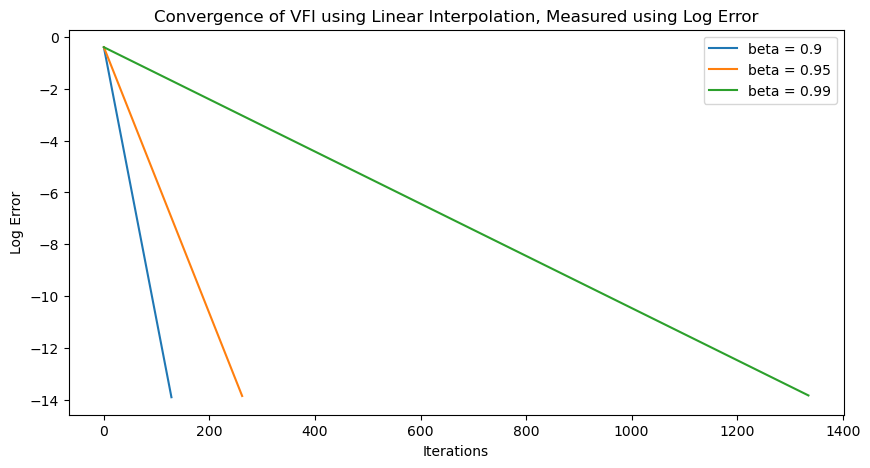


A key feature of value function iteration is that it will always converge geometrically to the true solution at
a rate proportional to beta. Beta is thus the factor that controls the rate of convergence—the smaller beta is, the
quicker the problem will converge, and the closer beta is to 1, the slower the problem will converge. Because beta
converges geometrically, we take the log of the errors to linearize the plot. The slopes of the log errors are 
negative as beta increases because the errors approach 0, and logs approach negative infinity as x approaches 0.

The slopes of the plots indicate the speed of convergence—the steeper the slope of log(error), the quicker 
convergence, as it reaches the tolerance level with fewer iterations. Thus, the slope allows us to more easily 
analyze the speed of convergence for the problem with differing levels of beta - the greater the magnitude of the
slope, the smaller the number of iterations, so the quicker convergence.

The number of iteratio

In [5]:
# Plotting figure of log errors against the number of iterations
plt.figure(figsize=(10, 5))

plt.plot(range(iterations1),np.log(errors1),label='beta = 0.9')
plt.plot(range(iterations2),np.log(errors2),label='beta = 0.95')
plt.plot(range(iterations3),np.log(errors3),label='beta = 0.99')

plt.legend()
plt.title('Convergence of VFI using Linear Interpolation, Measured using Log Error')
plt.xlabel('Iterations')
plt.ylabel('Log Error')

plt.show()


# Calculating the slopes; the errors converge at a tolerange of 10e-6
slope1 = np.log(10e-6)/iterations1
slope2 = np.log(10e-6)/iterations2
slope3 = np.log(10e-6)/iterations3

print(f'''
A key feature of value function iteration is that it will always converge geometrically to the true solution at
a rate proportional to beta. Beta is thus the factor that controls the rate of convergence—the smaller beta is, the
quicker the problem will converge, and the closer beta is to 1, the slower the problem will converge. Because beta
converges geometrically, we take the log of the errors to linearize the plot. The slopes of the log errors are 
negative as beta increases because the errors approach 0, and logs approach negative infinity as x approaches 0.

The slopes of the plots indicate the speed of convergence—the steeper the slope of log(error), the quicker 
convergence, as it reaches the tolerance level with fewer iterations. Thus, the slope allows us to more easily 
analyze the speed of convergence for the problem with differing levels of beta - the greater the magnitude of the
slope, the smaller the number of iterations, so the quicker convergence.

The number of iterations of convergence for each problem increased exponentially. The problem with beta = 0.9 
took {iterations1} iterations to converge, the problem with beta = 0.95 took {iterations2} iterations to converge, 
and the problem with beta = 0.99 took {iterations3} iterations to converge.

Dividing log(10e-6) by the number of iterations each problem took to converge, we obtain the slopes for each plot.
The slopes of the log errors are {round(slope1,3)} for beta = 0.9, {round(slope2,3)} for beta = 0.95, and {round(slope3,3)} for beta = 0.99, 
which indeed exhibits the key feature of slower convergence as beta approaches 1.''')

$c)$ For every starting value of $x$ on your grid, calculate the ratio $\frac{u'(c_t)}{u'(c_{t+1})}$ and plot the results for each of our three values of $\beta$. What do you notice? How can we interpret these results? To answer this, you will want to derive the Euler equation for this model. Does the Euler equation hold exactly in your numerical solution? If not, then explain why. Could you change anything in your solution algorithm to make it hold everywhere?

First, let us derive the Euler equation for this model. We have an infinitely lived person that has CRRA preferences and discounts time at the discount factor $\beta$. The person's cake constraint for each time period ensures that the amount of cake she has tomorrow is equal to the sum of the one cake she receives from the baker and the cake she currently has on hand minus the cake she eats.

The person maximizes her lifetime utility subject to her cake constraint in each period. We can thus write the person's maximization problem as the following Lagrangian:
$$\mathcal{L} = \sum_{t=0}^{\infty} \beta ^t \frac{c^{1-\sigma}}{1-\sigma} + \sum_{t=0}^{\infty} \lambda_t (1+x_t - c_t - x_{t+1})$$

where the $\lambda$'s are the Lagrange multipliers on each time period's $t$ cake constraint.

Here, the choice variables are $c_t$ and $x_{t+1}$ for all $t$. Intuitively, the person is trading off consumption and cake savings intertemporally; consumption today comes at the cost of saving more cake and thus consuming more cake in the future. The person's first-order conditions with respect to $c_t$ and $x_{t+1}$ are $\frac {\partial \mathcal{L}}{\partial c_t} = 0$ and $\frac {\partial \mathcal{L}}{\partial x_{t+1}} = 0$. As such, we have the following first-order conditions:

$$\frac {\partial \mathcal{L}}{\partial c_t} = \beta^t(1-\sigma)\frac{c_t^{-\sigma}}{1-\sigma} - \lambda_t = 0$$
$$\frac {\partial \mathcal{L}}{\partial c_t} = \beta^tc_t^{-\sigma} - \lambda_t = 0$$
and
$$\frac {\partial \mathcal{L}}{\partial x_{t+1}} = -\lambda_t + \lambda_{t+1} = 0$$

Plugging $\lambda_t = \beta^t(1-\sigma)\frac{c_t^{-\sigma}}{1-\sigma}$ and $\lambda_{t+1} = \beta^{t+1}(1-\sigma)\frac{c_{t+1}^{-\sigma}}{1-\sigma}$ into $\frac {\partial \mathcal{L}}{\partial x_{t+1}}$ yields

$$\beta^t c_t^{-\sigma} = \beta^{t+1} c_{t+1}^{-\sigma}$$

Simplifying, we obtain the Euler equation for this person, which describes her optimal path of cake consumption over time.
$$\Bigl(\frac{c_{t+1}}{c_t}\Bigr)^\sigma = \beta$$

Note that $u'(c_t) = c^{-\sigma}_t$ because the person's preferences are described by the CRRA utility function, so $\frac{u'(c_t)}{u'(c_{t+1})} = \frac{c^{-\sigma}_t}{c^{-\sigma}_{t+1}} = \Bigl(\frac{c_{t+1}}{c_t}\Bigr)^\sigma$.

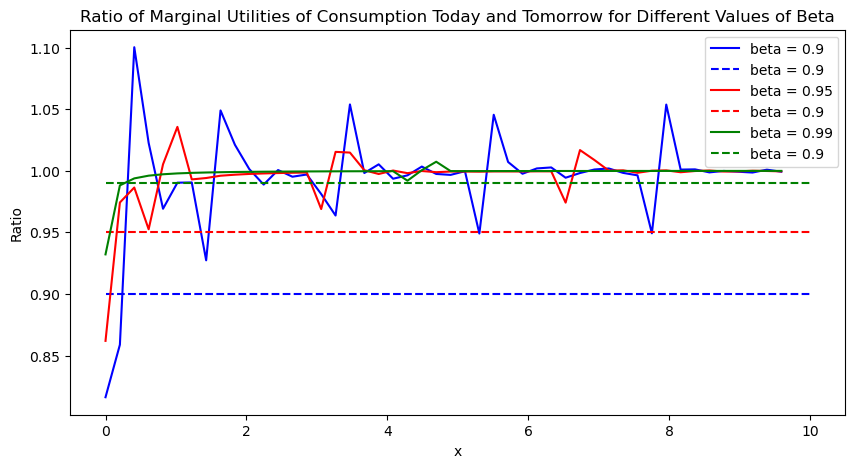


In theory, the Euler equation holds if the ratio of marginal utilities of consumption today and tomorrow equal the
discount factor beta. However, we can see that this is not the case in the figure below, as all three maximization
problems converge such that the ratio of marginal utilities approaches 1. As such, the Euler equation holds
imperfectly: convergence does indeed occur but not to the value it is meant to converge to.

For all three levels of beta, the ratio is the furthest from the solution for low levels of cake, and the path for
all three ratios fluctuate around 1 until convergence. This makes sense because when the person has no cake, she
she prefers to consume the cake today, as the marginal utility of consuming cake today is greater than saving the
cake for tomorrow. When she receives a unit of cake the following day, her marginal utility of consuming cake is
lower, since she had cake the previous day, so she prefers to save the cake for the day after. This continues
unt

In [6]:
# Calculating the ratio of marginal utilities for different values of beta

# beta = 0.9
c1 = [1 + x - policy1[i+1] for i, x in enumerate(policy1[:-1])]
c1 = np.array(c1)

u_prime_1 = c1 ** (-2.5) # The derivative of the CRRA utility function is c^(-sigma)

marginal_utility_ratio1 = [u_prime/u_prime_1[i+1] for i, u_prime in enumerate(u_prime_1[:-1])]
marginal_utility_ratio1 = np.array(marginal_utility_ratio1)


# beta = 0.95
c2 = [1 + x - policy2[i+1] for i, x in enumerate(policy2[:-1])]
c2 = np.array(c2)

u_prime_2 = c2 ** (-2.5) # The derivative of the CRRA utility function is c^(-sigma)

marginal_utility_ratio2 = [u_prime/u_prime_2[i+1] for i, u_prime in enumerate(u_prime_2[:-1])]
marginal_utility_ratio2 = np.array(marginal_utility_ratio2)


# beta = 0.99
c3 = [1 + x - policy3[i+1] for i, x in enumerate(policy3[:-1])]
c3 = np.array(c3)

u_prime_3 = c3 ** (-2.5) # The derivative of the CRRA utility function is c^(-sigma)

marginal_utility_ratio3 = [u_prime/u_prime_3[i+1] for i, u_prime in enumerate(u_prime_3[:-1])]
marginal_utility_ratio3 = np.array(marginal_utility_ratio3)


# Plotting
plt.figure(figsize=(10, 5))

plt.plot(p1.xgrid[:-2],marginal_utility_ratio1, color='b', label = 'beta = 0.9')
plt.plot([0,10],[0.9,0.9], color='b', label = 'beta = 0.9', linestyle='dashed')

plt.plot(p2.xgrid[:-2],marginal_utility_ratio2, color='r', label = 'beta = 0.95')
plt.plot([0,10],[0.95,0.95], color='r', label = 'beta = 0.9', linestyle='dashed')

plt.plot(p3.xgrid[:-2],marginal_utility_ratio3, color='g', label = 'beta = 0.99')
plt.plot([0,10],[0.99,0.99], color='g', label = 'beta = 0.9', linestyle='dashed')

plt.title('Ratio of Marginal Utilities of Consumption Today and Tomorrow for Different Values of Beta')
plt.xlabel('x')
plt.ylabel('Ratio')
plt.legend()

plt.show()

print('''
In theory, the Euler equation holds if the ratio of marginal utilities of consumption today and tomorrow equal the
discount factor beta. However, we can see that this is not the case in the figure below, as all three maximization
problems converge such that the ratio of marginal utilities approaches 1. As such, the Euler equation holds
imperfectly: convergence does indeed occur but not to the value it is meant to converge to.

For all three levels of beta, the ratio is the furthest from the solution for low levels of cake, and the path for
all three ratios fluctuate around 1 until convergence. This makes sense because when the person has no cake, she
she prefers to consume the cake today, as the marginal utility of consuming cake today is greater than saving the
cake for tomorrow. When she receives a unit of cake the following day, her marginal utility of consuming cake is
lower, since she had cake the previous day, so she prefers to save the cake for the day after. This continues
until she is indifferent between eating the cake today versus tomorrow.

Additionally, convergence is smoother and quicker the greater is beta; we can see that for beta = 0.9, the 
fluctuations around 1 are quite drastic: after the initial period, the marginal utility of consumption today 
fluctuates within being 10% greater and 10% lower than the marginal utility of consumption tomorrow.

I am not sure why the Euler equation holds imperfectly in the case of my code, but I hypothesize that it is to do
with the interplay between the lack of cake spoilage and the person's desire for smooth consumption. If the cake
spoils, balancing saving cake for the future and consuming today is more of a concern. This is due to sigma,
the consumption smoothing parameter which governs how much the person values consumption smoothing. If sigma is 
low, the person reacts strongly to another unit of cake, either sharply decreasing or increasing consumption, so 
they will save more cake initially. If sigma is extremely high, the person desires a more smooth consumption 
profile, so they will prefer to consume a cake each day rather than save. Thus, convergence is slower. 

If there is no threat of cake spoilage, the person eventually reaches a point when she is indifferent between
consuming today versus tomorrow, as there is no urgency to consume today. However, if the cake might spoil, then
the person would rather consume today. In this case, consumption today will be greater than consumption tomorrow,
so (c_{t+1}/c{t})^sigma will be less than 1 and potentially equal to beta. However, because there is an extra
parameter, it may not necessarily equal beta.

As such, to make the Euler equation hold everywhere, I would try adding a parameter for the rate of cake spoilage.
''')

# Exercise B2. Aiyagari with Disaster Shocks.
Consider the problem of an employed worker who is choosing how much to save for the future. They have human capital $y$ which is subject to shocks: $y$ follows an $AR(1)$ process with persistence $\rho$, drift $\mu$, and variance of the innovations $\sigma_\epsilon$. They can save at a risk-free rate $r$, but cannot borrow. They value consumption with a CRRA utility function $u(c) = c^{1−\sigma}/(1 − \sigma)$, and discount the future at a rate $\beta$.

So far, this looks just like the model we saw in class. We are going to add one more wrinkle: with a probability $\delta \in (0, 1)$, our worker receives a disaster shock and their income falls by a factor $\phi \in (0, 1)$. That is, if they would have had income $y'$, now they will receive $\phi y'$. You can think of this as a way of modeling a layoff at their firm. We can write their problem recursively as:

\begin{equation*}
\begin{aligned}
    v(a,y)=\max_{c,a'} \;\; & u(c)+\beta \mathbb{E}[(1-\delta)V(a',y')+\delta V(a',\phi y')|y] \\ 
    \text{s.t. } \;\; & c+a' \le (1+r)a+y \\ 
    \;\; & log(y') = \rho log(y) + \mu + e \\
    \;\; & e \sim N(0,\sigma_e) \\
\end{aligned}
\end{equation*}

Set $\sigma=2.5$,$\beta=0.95$,$r=0.03$,$\rho=0.7$,$\mu=0.5$,$\sigma_e=0.16$. That is, they have a 5% chance each period of losing 50% of their income.

$(a)$ First, consider the baseline case with $\delta = 0.4$. Solve this problem for $\sigma_e = 0.05$ and $\sigma_e = 0.16$. You can use any solution method that you like, but you should describe clearly any choices you have made (and justify them where necessary). Plot net savings $(a′ − a)$ as a function of assets for workers at five different (representative) points in the income distribution. How does the savings behavior of agents change as the variance of income shocks increases? Provide economic intuition for your results.

In the case of this part, since $\delta = 0$, the model collapses to the standard Bewley model. We will thus solve the Bewley model using value function iteration and multidimensional interpolation, since our value and policy functions are now 2 dimensional.

We follow the same procedure as in question B1. First, we define a class to store our parameters and set up our model, including the discretization of our income grid. Second, we define our CRRA utility function, accounting for the fact that sigma may be 1. Third, we define three functions to solve the Bewley model.

The first of the three functions is an outer while loop that simply checks whether or not our value function has converged, which indicates that the model is solved. The second function sits within the first function and interpolates (two dimensionally) through the points of our value function, solves for the maximum, and returns the consumption and asset values that produce the maximum. The third function is the function that performs the maximization step in the previous function.

After convergence, our value function is a two dimensional matrix where the rows indicate assets and the columns indicate income level. For each column (income level), the value function displays the maximum value achieved at each level of assets. We have two policy functions: one for consumption and one for assets. Both are also two dimensional matrices and can be interpreted in a similar manner as the value function. In particular, for each column in c_policy, each value in the column indicates the optimal amount of consumption for each level of assets.

In [7]:
# Class to store the parameters, value functions, and policy function
class b2_setup(object):
    
    def __init__(self, beta, r, rho, mu, sigma_e, delta, phi, Na, Ny):

        self.beta = beta
        self.r = r
        self.rho = rho
        self.mu = mu
        self.sigma_e = sigma_e
        self.delta = delta # Probability of receiving a disaster shock
        self.phi = phi # Proportion that income falls by if disaster shock occurs
        
        self.Na = Na
        self.Ny = Ny
        self.agrid = np.linspace(1e-4, 500, Na) 
        
        # Transition matrices transposed and income state values for the good state of income
        self.P = np.transpose(rouwenhorst(n=Ny, rho=rho, sigma=sigma_e, ybar=mu).P) # Transition matrix, good state
        self.ygrid = rouwenhorst(n=Ny, rho=rho, sigma=sigma_e, ybar=mu).state_values # Income state values
        
        # Transition matrices transposed and income state values for the disaster state of income, denoted d
        self.P_d = phi*np.transpose(rouwenhorst(n=Ny, rho=rho, sigma=sigma_e, ybar=mu).P) # Transition matrix
        
        self.V = np.zeros((Na, Ny))
        self.V0 = np.zeros((Na, Ny)) # Setting initial guess
        self.c_policy = np.zeros((Na, Ny))
        self.a_policy = np.zeros((Na, Ny))
        
# Defining CRRA utility function for vectored consumption, allowing for sigma == 1
def u(c, sigma=2.5):
    if c < 1e-8:
        return -np.infty
    
    if sigma == 1:
        return np.log(c)
    else:
        return (c ** (1-sigma))/(1 - sigma)

In [8]:
def solve_b2(params, tol = 1e-6, maxiter = 1000):
    
    beta, r, delta, agrid, P, ygrid, P_d, V, V0, c_policy, a_policy = params

    errors = []  # Vector of errors
    iterations = 0
    
    while True:
        sys.stdout.write(f'Iteration {iterations}\r')
        sys.stdout.flush()
        
        iterations += 1
        
        # Calculating expectations
        EV = deepcopy(V0@P)
        
        # Updating Bellman equation
        update_bellman_b2(params, EV)
        
        # Calculating and saving errors
        error = np.max(np.abs(V - V0))
        errors.append(error)
        
        # Checking for convergence
        if error < tol or iterations >= maxiter:
            break   
            
        # Update value function
        V0 = deepcopy(V)
    
    return V, c_policy, a_policy, iterations, errors


def update_bellman_b2(params, EV):
    
    beta, r, delta, agrid, P, ygrid, P_d, V, V0, c_policy, a_policy = params

    # Interpolate the expectations
    EV_hat = RectBivariateSpline(agrid, ygrid, EV)
    
    # Looping through each income slice of the grid    
    for j, y in enumerate(ygrid):
        
        # Solving inner maximization problem for each point on the asset grid
        for i, a in enumerate(agrid):
            v_p, c, a = solve_inner_b2(a, y, EV_hat, params)
            
            # Saving the results
            V[i,j] = v_p
            c_policy[i,j] = c
            a_policy[i,j] = a
            
def solve_inner_b2(a, y, EV_hat, params):
    
    beta, r, delta, agrid, P, ygrid, P_d, V, V0, c_policy, a_policy = params
        
    # Calculate cash on hands: output plus undepreciated capital
    z  = (1+r)*a + np.exp(y) # e^y due to log(y)
    
    # Set up the objective function in terms of consumption
    def obj(a_p):
        c = z - a_p
        return -(u(c) + beta * EV_hat(a_p, y)[0][0])
    
    # Setting initial guess and bounds for optimization problem
    a_p_bounds = (1e-6,z-1e-6)
    
    # Solving optimization problem using scipy.optimize.minimize
    solution = optimize.minimize_scalar(obj, bounds=a_p_bounds, method='bounded')
    
    # Recovering the optimal values and optimal policies
    v_p   = -solution.fun
    a_p   = solution.x
    c     = z - a_p
    
    # Returning results
    return v_p, c, a_p

In [9]:
p1 = b2_setup(0.95, 0.03, 0.7, 0.5, 0.05, 0.05, 0.5, 100, 30)
params1 = [p1.beta, p1.r, p1.delta, p1.agrid, p1.P, p1.ygrid, p1.P_d, p1.V, p1.V0, p1.c_policy, p1.a_policy]

V1, c_policy1, a_policy1, iterations1, errors1 = solve_b2(params1)

In [10]:
p2 = b2_setup(0.95, 0.03, 0.7, 0.5, 0.16, 0.05, 0.5, 100, 30)
params2 = [p2.beta, p2.r, p2.delta, p2.agrid, p2.P, p2.ygrid, p2.P_d, p2.V, p2.V0, p2.c_policy, p2.a_policy]

V2, c_policy2, a_policy2, iterations2, errors2 = solve_b2(params2)

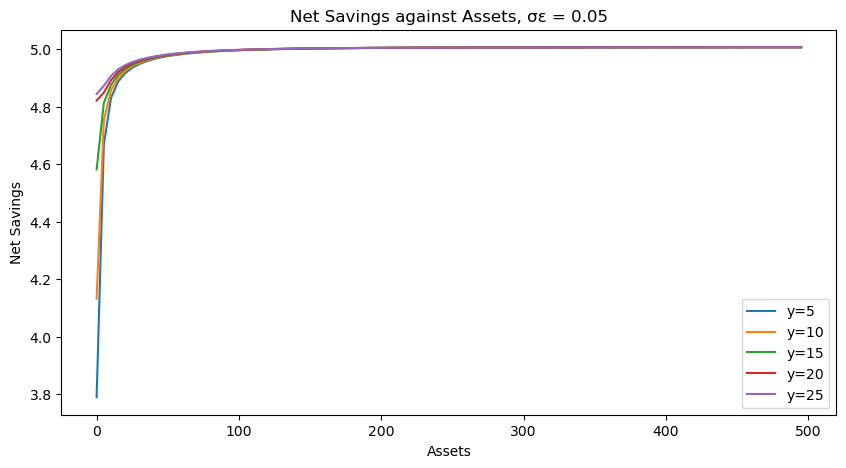

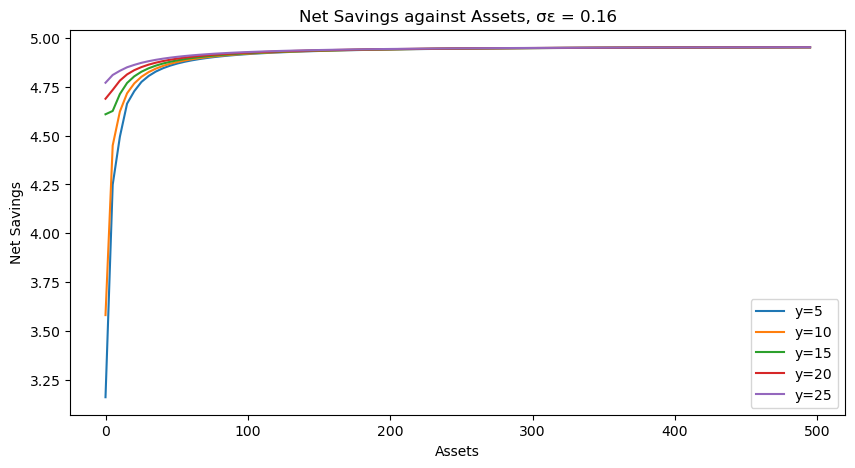


The plot above shows net savings as a function of assets for workers at five representative points on the income
distribution. To pick the points in the income distribution, I used columns in the assets policy function that 
were multiples of five.

For both plots, we observe net savings converging to a level of 5 from below, indicating that agents tend to
accumulate assets over time. This is consistent with individual intertemporal savings and consumption decisions,
where individuals have a consumption smoothing preference and thus tend to save during their working years
such that consumption need not fall drastically during their retirement. Those at higher income levels can afford
to start with higher savings and are thus able to converge to the optimal level of assets quicker than those at 
lower income levels. We observe between the two plots that as the variance of income shock increases, convergence 
to optimal level of net savings is slower. We hypothesize that this is due to 

In [23]:
y_vals = list(map(int, np.arange(1,6) * (p1.Ny/6)))

fig = plt.figure(figsize=(10, 5))
for y in y_vals:
    a_pol = np.transpose(a_policy1)
    net_savings = []
    for i in range(p1.Na - 1):
        net_savings.append(a_pol[y][i+1] - a_pol[y][i])
    plt.plot(p1.agrid[:-1], net_savings, label = f'y={y}')

plt.legend()
plt.title('Net Savings against Assets, σε = 0.05')
plt.xlabel('Assets')
plt.ylabel('Net Savings')
plt.show()

fig = plt.figure(figsize=(10, 5))
for y in y_vals:
    a_pol = np.transpose(a_policy2)
    net_savings = []
    for i in range(p2.Na - 1):
        net_savings.append(a_pol[y][i+1] - a_pol[y][i])
    plt.plot(p2.agrid[:-1], net_savings, label = f'y={y}')

plt.legend()
plt.title('Net Savings against Assets, σε = 0.16')
plt.xlabel('Assets')
plt.ylabel('Net Savings')
plt.show()

print(f'''
The plot above shows net savings as a function of assets for workers at five representative points on the income
distribution. To pick the points in the income distribution, I used columns in the assets policy function that 
were multiples of five.

For both plots, we observe net savings converging to a level of 5 from below, indicating that agents tend to
accumulate assets over time. This is consistent with individual intertemporal savings and consumption decisions,
where individuals have a consumption smoothing preference and thus tend to save during their working years
such that consumption need not fall drastically during their retirement. Those at higher income levels can afford
to start with higher savings and are thus able to converge to the optimal level of assets quicker than those at 
lower income levels. We observe between the two plots that as the variance of income shock increases, convergence 
to optimal level of net savings is slower. We hypothesize that this is due to heterogeneity in the responses to
uncertainty - some individuals may prefer to consume more in the current period, as future income is no longer
guaranteed, while others may prefer to accumulate safe assets such as government bonds.

Additionally, we note that for the case of sigma_e = 0.16, there is a steep fall in net savings for high levels of
assets among the highest level of income. This implies that for the very rich, they may have a preference to
consume more in the face of uncertainty, as there is less incentive to save.
''')

$b)$ Now, consider the case with $\sigma_e=0.16$, $\delta = 0.05$, and $\phi = 0.5$. Solve this problem any way that you like. Describe clearly the choices you have made, and justify them where necessary. Note, you will not be able to get around interpolating V, since $\phi y'$ does not need to lie on the income grid. Plot the policy functions for consumption and net savings $(a′ − a)$ with assets on the x-axis, and a separate line for several different values of $y$. (Pick representative values). Interpret the results. What does the shape of the policy functions tell you about the underlying economics of this problem?

Here, since $\delta \neq 0$, so we can no longer use the standard Bewley model and must instead account for uncertainty in the form of a random disaster such as job loss. We follow the same procedure as in part (a) except that to address the chance of random job loss, we need to consider two possible scenarios for income in the future: one with job loss and one without.

We account for this in our function by calculating expectations for EV and EV_d (d for disaster) in the outer loop, interpolate through both scenarios in the interpolation loop, and solve the objective function to maximize individual utility, taking the expected value of job loss in the future period. Specifically, we multiply $\delta$ by the interpolated expected value in the case of job loss and $(1-\delta)$ by the standard interpolated expected value of income in the next period.

Our value and policy functions remain the same as in above.

In [12]:
def solve_b2b(params, tol = 1e-6, maxiter = 1000):
    
    beta, r, delta, agrid, P, ygrid, P_d, V, V0, c_policy, a_policy = params

    errors = []  # Vector of errors
    iterations = 0
    
    while True:
        sys.stdout.write(f'Iteration {iterations}\r')
        sys.stdout.flush()
        
        iterations += 1
        
        # Calculating expectations for EV and EV_d
        EV = deepcopy(V0@P)
        EV_d = deepcopy(V0@P_d)
        
        # Updating Bellman equation
        update_bellman_b2b(params, EV, EV_d)
        
        # Calculating and saving errors
        error = np.max(np.abs(V - V0))
        errors.append(error)
        
        # Checking for convergence
        if error < tol or iterations >= maxiter:
            break   
            
        # Update value function
        V0 = deepcopy(V)
    
    return V, c_policy, a_policy, iterations, errors


def update_bellman_b2b(params, EV, EV_d):
    
    beta, r, delta, agrid, P, ygrid, P_d, V, V0, c_policy, a_policy = params

    # Interpolate the expectations for EV and EV_d
    EV_hat = RectBivariateSpline(agrid, ygrid, EV)
    EV_hat_d = RectBivariateSpline(agrid, ygrid, EV_d)

    # Looping through each income slice of the grid    
    for j, y in enumerate(ygrid):
        
        # Solving inner maximization problem for each point on the asset grid
        for i, a in enumerate(agrid):
            v_p, c, a = solve_inner_b2b(a, y, EV_hat, EV_hat_d, params)
            
            # Saving the results
            V[i,j] = v_p
            c_policy[i,j] = c
            a_policy[i,j] = a
            
def solve_inner_b2b(a, y, EV_hat, EV_hat_d, params):
    
    beta, r, delta, agrid, P, ygrid, P_d, V, V0, c_policy, a_policy = params
        
    # Calculate cash on hands: output plus undepreciated capital
    z  = (1+r)*a + np.exp(y) # e^y due to log(y)
    
    # Set up the objective function in terms of consumption
    def obj(a_p):
        c = z - a_p
        return -(u(c) + beta * ((1-delta)*EV_hat(a_p, y)[0][0] + delta*EV_hat_d(a_p, y)[0][0]))
    
    # Setting initial guess and bounds for optimization problem
    a_p_bounds = (1e-6,z-1e-6)
    
    # Solving optimization problem using scipy.optimize.minimize
    solution = optimize.minimize_scalar(obj, bounds=a_p_bounds, method='bounded')
    
    # Recovering the optimal values and optimal policies
    v_p   = -solution.fun
    a_p   = solution.x
    c     = z - a_p
    
    # Returning results
    return v_p, c, a_p

In [13]:
V2b, c_policy2b, a_policy2b, iterations2b, errors2b = solve_b2b(params2)

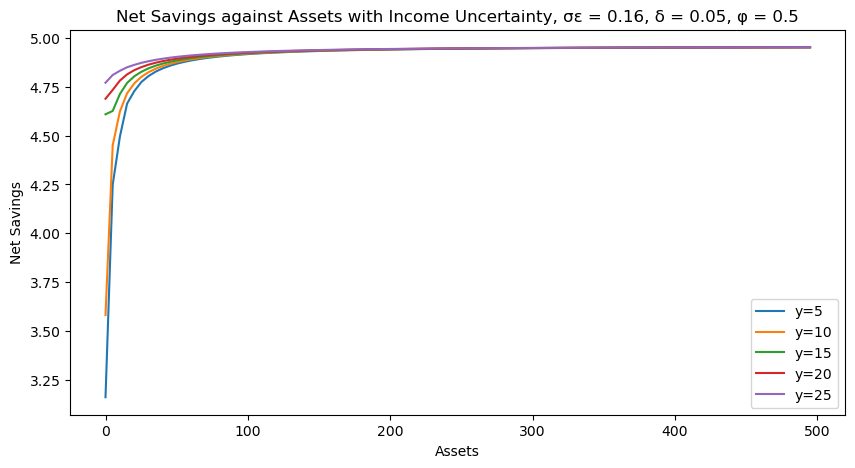

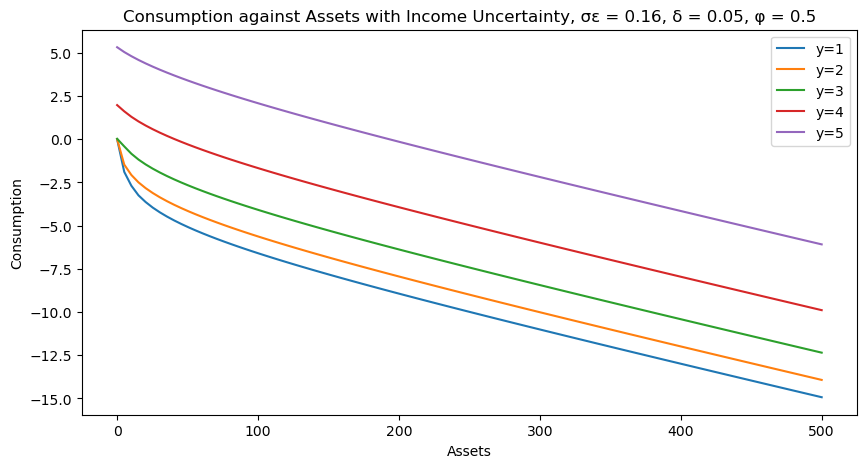


Again, the plot for net savings as a function of assets resembles the plots of part (a), in which agents tend to
accumulate assets over time, in particular to a savings level of 5. With greater uncertainty, there seems to be
even slower convergence to the assets level, again due to individual heterogeneity in consumption versus savings
decisions.

The plot for consumption shows that consumption decreases as assets increase for all income levels, and those
with higher levels of income enjoy greater consumption than those with lower levels of income. As assets become 
extremely high, consumption becomes negative due to the trade off between consumption and savings. Overall, the
consumption paths for individuals at all income levels are quite smooth, with the smoothest consumption path
being those with higher income levels. Individuals with lower levels of income exhibit a steep drop in consumption
when assets are low, which is consistent with the intuition that lower income individuals 

In [24]:
# Plot of net savings against assets with possibility of disaster

fig = plt.figure(figsize=(10, 5))
for y in y_vals:
    a_pol = np.transpose(a_policy2b)
    net_savings = []
    for i in range(p2.Na - 1):
        net_savings.append(a_pol[y][i+1] - a_pol[y][i])
    plt.plot(p2.agrid[:-1], net_savings, label = f'y={y}')

plt.legend()
plt.title('Net Savings against Assets with Income Uncertainty, σε = 0.16, δ = 0.05, φ = 0.5')
plt.xlabel('Assets')
plt.ylabel('Net Savings')
plt.show()

# Plot of consumption against assets with possibility of disaster

fig = plt.figure(figsize=(10, 5))
for i,y in enumerate(y_vals):
    a_pol = np.transpose(a_policy2b)
    consumption = a_pol[y] - p2.agrid
    plt.plot(p2.agrid, consumption, label = f'y={i+1}')

plt.legend()
plt.title('Consumption against Assets with Income Uncertainty, σε = 0.16, δ = 0.05, φ = 0.5')
plt.xlabel('Assets')
plt.ylabel('Consumption')
plt.show()

print(f'''
Again, the plot for net savings as a function of assets resembles the plots of part (a), in which agents tend to
accumulate assets over time, in particular to a savings level of 5. With greater uncertainty, there seems to be
even slower convergence to the assets level, again due to individual heterogeneity in consumption versus savings
decisions.

The plot for consumption shows that consumption decreases as assets increase for all income levels, and those
with higher levels of income enjoy greater consumption than those with lower levels of income. As assets become 
extremely high, consumption becomes negative due to the trade off between consumption and savings. Overall, the
consumption paths for individuals at all income levels are quite smooth, with the smoothest consumption path
being those with higher income levels. Individuals with lower levels of income exhibit a steep drop in consumption
when assets are low, which is consistent with the intuition that lower income individuals have a higher marginal
propensity to consume. This plot can provide insights into how individuals allocate their resources over time,
specifically between consumption and savings.

As for my code, my graphs, and thus my code, are likely slightly off. I think that the reason for this may be that
in part (a), my maximization problem hit the bounds of the grid and was unable to provide an adequate solution. 
Additionally, I accounted for the posibility of disaster in my initial setup function. Specifically, I created an 
income transition matrix using the Rouwenhorst method from QuantEcon with the same rho, mu, and sigma_e and 
multiplied the transition matrix by phi—the drop in income if a disaster occurs. I am not entire sure of whether
or not this was the correct approach, but it made sense intuitively to me to proceed in this manner.

Additionally, it is interesting to note that the problem with income uncertainty took less iterations to evolve.
This may be that income uncertainty disrupts the smoothness of consumption, so convergence is quicker, though I
am not entirely sure about the intuition of this result.
''')

$c)$ Play around with the values of $\delta$ and $\phi$. Simulate data from the model and compare the distribution of assets under the various scenarios. In particular, make sure to check $\delta = 0, 0.05, 0.2$ and $0.3$, with $\phi=0.5$. How does $\delta$ effect the distribution of assets in the economy? Provide economic intuition for the results.

To simulate data from our model, we follow a version of the simulated method of moments algorithm. In the case of the Aiyagari model, we first solve the model for various parameter values that we want to simulate data for, recovering the policy rules for assets and income. Second, We start from the initial state of assets and income, and draw a random sequence of income values that satisfy the stochastic AR(1) process for income. The possibility of job loss makes sense step slightly more complex. Finally, for each time period after the initial period, we obtain the simulated data, following the rule of 
$$a_t = g_k(a_{t-1}, y_{t-1})$$
$$c = g_c(a_{t}, y_{t})$$

Simulating data from our model relies on a large number of agents and time periods, as we want the distribution of assets in the economy to converge to the true distribution such that we can draw a random variable from the true distribution. This allows us to achieve more realistic results and estimate the model to match empirical data, which is especially useful if we want to model the effects of economic policy.

Before simulating data, we first need to solve our model for various values of delta, with phi = 0.5. delta = 0 is given by the results of part (a), and delta = 0.05 is given by te results of part (b). As such, we need only solve for delta = 0.2 and delta = 0.3, which occur below.

In [19]:
p3 = b2_setup(0.95, 0.03, 0.7, 0.5, 0.16, 0.2, 0.5, 100, 30)
params3 = [p3.beta, p3.r, p3.delta, p3.agrid, p3.P, p3.ygrid, p3.P_d, p3.V, p3.V0, p3.c_policy, p3.a_policy]

V3, c_policy3, a_policy3, iterations3, errors3 = solve_b2(params3)

In [20]:
p4 = b2_setup(0.95, 0.03, 0.7, 0.5, 0.16, 0.3, 0.5, 100, 30)
params4 = [p4.beta, p4.r, p4.delta, p4.agrid, p4.P, p4.ygrid, p4.P_d, p4.V, p4.V0, p4.c_policy, p4.a_policy]

V4, c_policy4, a_policy4, iterations4, errors4 = solve_b2(params4)

In [21]:
# Creating function to simulate data from the model

def simulate(params, apolicy, cpolicy, N=10000, T=1000): # Simulating 10,000 agents for 1,000 time periods to 
                                                         # ensure that we converge to a stationary distribution
    beta, r, delta, agrid, P, ygrid, P_d, V, V0, c_policy, a_policy = params
    a = np.ones(N) * np.mean(agrid)
    y = np.ones(N) * ygrid[int(len(ygrid)/2)]
    Pc = np.cumsum(P, axis=1)
    
    a_hat = RectBivariateSpline(agrid, ygrid, apolicy)
    c_hat = RectBivariateSpline(agrid, ygrid, cpolicy)
           
    for t in range(T):
        for i in range(N):
           
            # Step assets forward
            a_p = a_hat(a[i],y[i])
            a[i] = a_p

            # Step income forward
            z = np.random.uniform()
            y_i = np.searchsorted(ygrid, y[i])
            y_i_p = np.searchsorted(Pc[:,y_i], z)
            y[i] = ygrid[y_i_p-1]
           
    c = c_hat(a, y)

    return a, y, c

In [26]:
# simulate(params1, a_policy1b, c_policy1b, N=10000, T=1000)

print('''My function to simulate data failed to run after 3 minutes; indicates that the for-loop was working for 
initial time periods and agents but crashed at upper levels.''')

My function to simulate data failed to run after 3 minutes; indicates that the for-loop was working for 
initial time periods and agents but crashed at upper levels.


Our function to simulate data from the model failed to run after a few minutes, which indicates that it likely works for initial values for assets and consumption; I am unsure of where exactly the function has an error, as the error message stated that a grid must be strictly increasing. I assume that the error is referring to ygrid, since agrid is strictly increasing and we discretized ygrid into a Markov Chain. However, I am unsure of how to address this error.

Despite this, I can hypothesize as to delta's effect on the distribution of assets in the economy. First, the distribution of assets in the economy will be right skewed, as in Problem Set 7. This is due to wealth inequality
that exists within any economy. Second, delta represents the probability that a worker receives a disaster shock, 
causing her income to fall. 

Thus, the smaller delta, the more income certainty a person has, so the less right skewed the asset distribution is; Agents will have more similar responses in consumption/savings behaviour if their income is relatively more guaranteed, and due to the preference to smooth consumption, there will be fewer individuals with extreme values of assets in the economy.

Conversely, the greater delta, the greater income uncertainty, which will cause assets to be more right skewed. This is due to heterogeneity in the responses to income uncertainty. In a more uncertain economic environment, individuals become more risk-averse, making them more likely to save more or hold safer assets such as bonds. Thus, there will likely be higher levels of assets than compared to a lower delta. On the other hand, income uncertainty may also cause individuals to be more short-sighted, prioritizing short term needs with the income that they have, leaving to less assets. Thus, the assets distribution for a greater delta will have a greater spread.